<a href="https://colab.research.google.com/github/Carlos-Pessin/Clustering_RFM_Python/blob/main/Clustering_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Business Understanding
A UK-based e-commerce company has hired DNC students to group their customers based on RFM metrics (discussed below) to then define customer loyalty strategies.

RFM:

R (Recency): The time since the customer's last purchase (in days)
F (Frequency): The number of purchases made by the customer
M (Monetary): The average ticket value spent by the customer
The provided dataset contains transactions that occurred between December 2010 and December 2011.

Your objective is to cluster the customers based on their RFM metrics.

Dataset source in [this link.](https://www.kaggle.com/datasets/carrie1/ecommerce-data).

# Step 2 : Data Understanding

## Setup

In [ ]:
import numpy as np
import pandas as pd

import plotly.express as px
import seaborn as sns
import sidetable
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import kelbow_visualizer

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

## Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/cmcouto-silva/datasets/main/datasets/e-commerce.csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data understanding

In [ ]:
df.info()       # InvoiceData and Customer ID formats are wrong

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.InvoiceNo.sort_values()      # InvoiceNo has letters, so its format is right

,InvoiceNo
0,536365
1,536365
2,536365
3,536365
4,536365
...,...
540449,C581490
541541,C581499
541715,C581568
541716,C581569


In [ ]:
df[['Description','Country']].nunique()         # Lots of different values

,0
Description,4223
Country,38


In [ ]:
df.stb.freq(['Country'])      # more than 90% from UK, does the stakeholder wants to analyse it all together?

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [ ]:
df[['Quantity','UnitPrice']].describe()       # there are negative values for both, which cant be right

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


# Step 3 : Data Preparation

## Data Cleaning

In [ ]:
df = df.dropna(subset=['CustomerID'])     # key information, cant do anything without it

In [ ]:
df.stb.missing()      # all missing values are gone

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

In [ ]:
df = df.copy()    # stop warnings

In [ ]:
df.info()       # now it is correct

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


In [ ]:
df.InvoiceDate.agg(['min','max'])     # examining dates

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00


In [ ]:
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)     # since we cant ask, we'll remove senseless values for this columns
df = df[~below0].copy()

Outlier analisys

<Axes: >

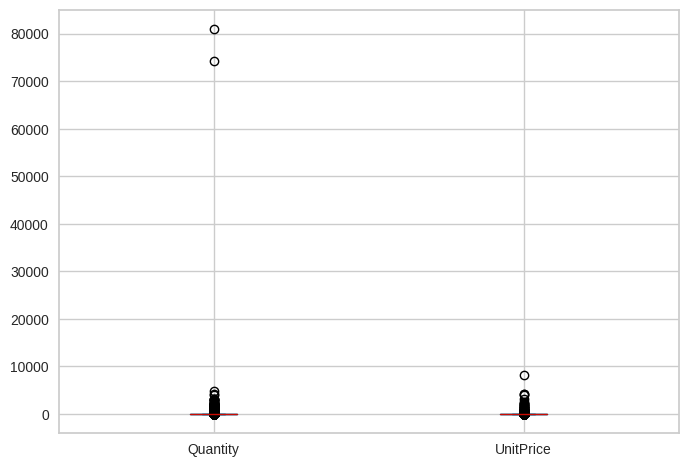

In [ ]:
df[['Quantity','UnitPrice']].plot.box()

<Axes: >

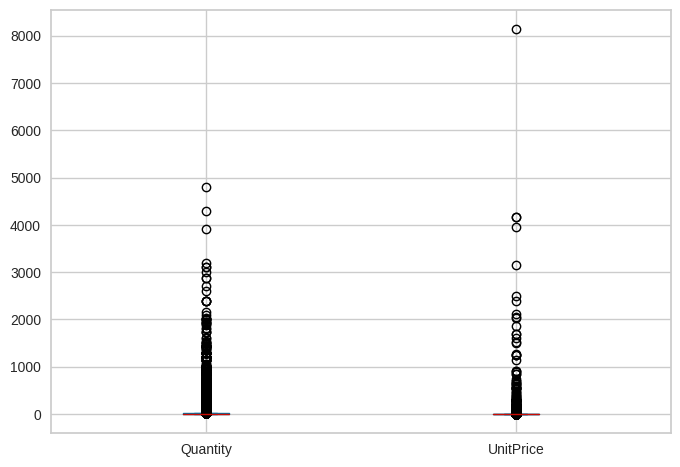

In [ ]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [ ]:
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()       # removing far outliers

## Construct Data

In [ ]:
df['price_total'] = df.Quantity * df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


RFM

In [ ]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),     # using 2012 to make it reasonable
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)

df_rfm.head()

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824


<Axes: >

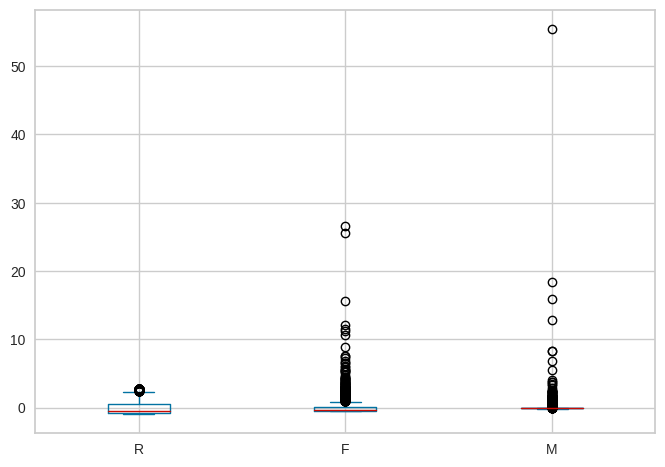

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.899878,-0.165317,55.434876


In [ ]:
df.query('CustomerID==15098')         # idx 222680 seems wrong, did the bought 60 of 60 pieces?

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [ ]:
df_rfm = df_rfm.drop(15098)   # Removing since we cant check

<Axes: >

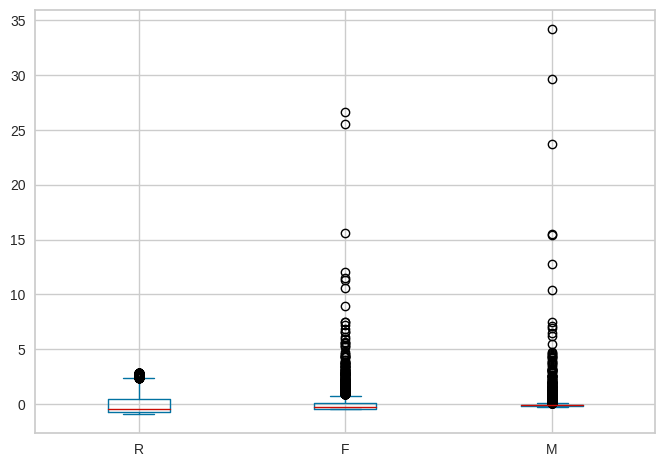

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
scaler = PowerTransformer()
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563219,1.201866,0.407836
12348,0.323470,0.660670,1.329304
12349,-0.809134,-1.158070,0.426829
12350,1.568467,-1.158070,0.189376
12352,-0.307718,1.309671,0.653411
...,...,...,...
18280,1.475652,-1.158070,0.085562
18281,1.107356,-1.158070,-0.491003
18282,-1.275046,-0.195707,-0.161007


<Axes: >

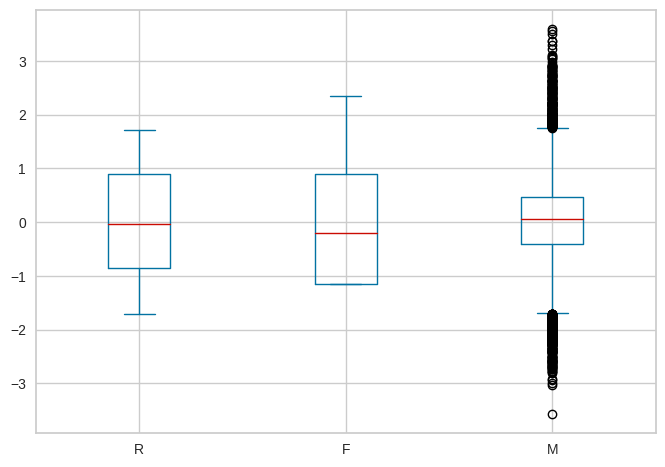

In [ ]:
df_rfm_scaled.plot.box()

In [ ]:
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.554185
std,99.968352,7.697927,129.202663
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,395.000000,209.000000,4453.430000


In [ ]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))       # its necessary to remove outliers for clustering
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


In [ ]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

# Step 4-5: Modeling & Model evaluation

In [ ]:
X = df_rfm_clip_scaled.copy()

## K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

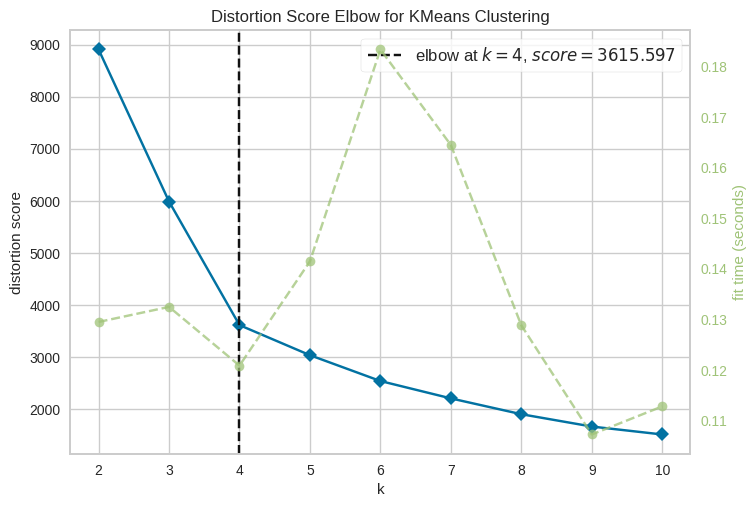

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10))

In [ ]:
kelbow_visualizer(KMeans(), X)

In [ ]:
# Assessing possible parameters

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(3,8):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
3,5987.858046,0.434196,0.858749,2539.996344
4,3615.611638,0.479553,0.704462,3751.144746
5,3038.336417,0.484900,0.737632,3552.816991
6,2542.520604,0.397827,0.851265,3564.615894
7,2209.185328,0.376864,0.870175,3526.795460


In [ ]:
model_Kmeans = KMeans(n_clusters=4)       # 4 was chosen
labels_Kmeans = model_Kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
Results = pd.DataFrame({'Model': 'Kmeans',
                        'N_clusters': [4],
                        'Silhoutte':  [silhouette_score(X, labels_Kmeans)],
                        'Davies Bouldin': [davies_bouldin_score(X, labels_Kmeans)],
                        'Calinski Harabasz': [calinski_harabasz_score(X, labels_Kmeans)]
                        })
Results

,Model,N_clusters,Silhoutte,Davies Bouldin,Calinski Harabasz
0,Kmeans,4,0.479553,0.704462,3751.144746


In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=labels_Kmeans.astype(str), template='plotly_dark')

## Hierarchical Clustering

In [ ]:
# Assessing possible parameters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='coolwarm')

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.361292,1.331666,1737.623791
3,0.398928,0.869855,2104.783905
4,0.431886,0.761966,2770.399918
5,0.342136,0.897329,2872.239315
6,0.348298,0.791909,2816.854970
7,0.322680,0.844326,2848.491623
8,0.287643,0.967432,2799.001327
9,0.286883,0.976982,2832.797336
10,0.298923,0.953087,2786.657350


In [ ]:
model_HCluster = AgglomerativeClustering(n_clusters=4)    # chose 4
labels_HCluster = model_HCluster.fit_predict(df_rfm_clip_scaled)

In [ ]:
Results.loc[1] = ['Hierarchical Clustering',
                  4,
                  silhouette_score(X, labels_HCluster),
                  davies_bouldin_score(X, labels_HCluster),
                  calinski_harabasz_score(X, labels_HCluster)
                  ]
Results

,Model,N_clusters,Silhoutte,Davies Bouldin,Calinski Harabasz
0,Kmeans,4,0.479553,0.704462,3751.144746
1,Hierarchical Clustering,4,0.431886,0.761966,2770.399918


In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=labels_HCluster.astype(str), template='plotly_dark')

## DBSCAN

In [ ]:
# Assessing possible parameters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for eps in [0.25, 0.5, 0.75, 1]:
  for min_samples in [50, 100, 150, 200]:
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)
    if pd.Series(labels).nunique() > 1:     # mais de um cluster
      cluster_results_dict = {'eps': eps, 'min_samples': min_samples}
      cluster_results_dict['n_Clusters'] = pd.Series(labels).nunique()
      for metric in cluster_metrics:
        cluster_results_dict[metric.__name__] = metric(X, labels)
      cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).style.background_gradient(subset=['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'], cmap='coolwarm')

,eps,min_samples,n_Clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,0.250000,50,9,-0.048798,1.816576,352.898755
1,0.250000,100,6,-0.234388,1.630179,175.401283
2,0.250000,150,3,-0.255236,1.777078,63.102253
3,0.500000,50,3,0.412949,1.320880,733.150217
4,0.500000,100,3,0.405191,1.037613,1388.748320
5,0.500000,150,3,0.365955,1.276635,1014.593326
6,0.500000,200,2,0.388841,1.663314,1297.084807
7,0.750000,50,4,0.383412,1.090705,308.630411
8,0.750000,100,2,0.502735,0.999900,1445.286349
9,0.750000,150,2,0.491731,1.034368,1476.179057


In [ ]:
model_DBSCAN = DBSCAN(eps=0.5, min_samples=100)
labels_DBSCAN = model_DBSCAN.fit_predict(X)

In [ ]:
Results.loc[2] = ['DBSCAN',
                  3,
                  silhouette_score(X, labels_DBSCAN),
                  davies_bouldin_score(X, labels_DBSCAN),
                  calinski_harabasz_score(X, labels_DBSCAN)
                  ]
Results

,Model,N_clusters,Silhoutte,Davies Bouldin,Calinski Harabasz
0,Kmeans,4,0.479553,0.704462,3751.144746
1,Hierarchical Clustering,4,0.431886,0.761966,2770.399918
2,DBSCAN,3,0.405191,1.037613,1388.748320


In [ ]:
px.scatter_3d(X, x='R', y='F', z='M', color=labels_DBSCAN.astype(str), template='plotly_dark')

## Mean Shift

In [ ]:
# Assessing possible parameters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for bandwidth in [1, 1.25, 1.5, 1.75]:
  model = MeanShift(bandwidth=bandwidth)
  labels = model.fit_predict(X)
  if pd.Series(labels).nunique() > 1:
    cluster_results_dict = {'bandwidth': bandwidth}
    cluster_results_dict['n_Clusters'] = pd.Series(labels).nunique()
    for metric in cluster_metrics:
      cluster_results_dict[metric.__name__] = metric(X, labels)
    cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).style.background_gradient(subset=['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'], cmap='coolwarm')

,bandwidth,n_Clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,1.000000,8,0.468804,0.848237,2269.620178
1,1.250000,5,0.424311,0.804722,1941.815836
2,1.500000,3,0.424423,0.898713,1168.892261
3,1.750000,2,0.495776,1.086760,1430.737764


In [ ]:
model_MeanShift = MeanShift(bandwidth=1.25)
labels_MeanShift = model_MeanShift.fit_predict(X)

In [ ]:
Results.loc[3] = ['MeanShift',
                  5,
                  silhouette_score(X, labels_MeanShift),
                  davies_bouldin_score(X, labels_MeanShift),
                  calinski_harabasz_score(X, labels_MeanShift)
                  ]
Results

,Model,N_clusters,Silhoutte,Davies Bouldin,Calinski Harabasz
0,Kmeans,4,0.479553,0.704462,3751.144746
1,Hierarchical Clustering,4,0.431886,0.761966,2770.399918
2,DBSCAN,3,0.405191,1.037613,1388.748320
3,MeanShift,5,0.424311,0.804722,1941.815836


In [ ]:
px.scatter_3d(X, x='R', y='F', z='M', color=labels_MeanShift.astype(str), template='plotly_dark')

## Gaussian Mixture

In [ ]:
# Create list of dictionaries
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for n_components in range(2,7):
  for covariance_type in ['full', 'tied', 'diag', 'spherical']:
    model = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    labels = model.fit_predict(X)
    cluster_results_dict = {'n_components': n_components}
    cluster_results_dict['covariance_type'] = covariance_type
    cluster_results_dict['BIC'] = model.bic(X)
    for metric in cluster_metrics:
      cluster_results_dict[metric.__name__] = metric(X, labels)
    cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).style.background_gradient(subset=['BIC', 'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'], cmap='coolwarm')

,n_components,covariance_type,BIC,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,2,full,29524.583738,0.344932,1.525124,1534.762331
1,2,tied,32302.729835,0.493423,0.969426,1507.673607
2,2,diag,30540.477623,0.297273,1.336648,1760.603432
3,2,spherical,32645.826194,0.250133,1.939278,764.098297
4,3,full,25982.847234,0.277947,1.280494,1619.425908
5,3,tied,30606.361588,0.440101,0.823392,2415.199934
6,3,diag,26400.284942,0.290824,1.256283,1701.068833
7,3,spherical,29514.284832,0.401255,1.241886,1967.958801
8,4,full,24739.258490,0.327479,1.184171,1968.092706
9,4,tied,29100.364184,0.473934,0.697443,3512.858438


In [ ]:
model_GaussMix = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
label_GaussMix = model_GaussMix.fit_predict(X)

In [ ]:
Results.loc[4] = ['Gaussian Mixture',
                  5,
                  silhouette_score(X, label_GaussMix),
                  davies_bouldin_score(X, label_GaussMix),
                  calinski_harabasz_score(X, label_GaussMix)
                  ]
Results

,Model,N_clusters,Silhoutte,Davies Bouldin,Calinski Harabasz
0,Kmeans,4,0.479553,0.704462,3751.144746
1,Hierarchical Clustering,4,0.431886,0.761966,2770.399918
2,DBSCAN,3,0.405191,1.037613,1388.748320
3,MeanShift,5,0.424311,0.804722,1941.815836
4,Gaussian Mixture,5,0.123541,2.410132,1345.178021


In [ ]:
px.scatter_3d(X, x='R', y='F', z='M', color=label_GaussMix.astype(str), template='plotly_dark')

## Evaluation

In [ ]:
Results.set_index('Model').style.background_gradient(cmap='coolwarm')

,N_clusters,Silhoutte,Davies Bouldin,Calinski Harabasz
Model,,,,
Kmeans,4,0.479553,0.704462,3751.144746
Hierarchical Clustering,4,0.431886,0.761966,2770.399918
DBSCAN,3,0.405191,1.037613,1388.748320
MeanShift,5,0.424311,0.804722,1941.815836
Gaussian Mixture,5,0.123541,2.410132,1345.178021


Kmeans did better

# Step 5: Interpretação dos clusters

In [ ]:
centers = (pd.DataFrame(model_Kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)
           )
centers.T.add_prefix('Cluster_')

,Cluster_0,Cluster_1,Cluster_2,Cluster_3
R,-0.468355,-0.740690,1.558575,0.092255
F,-0.269244,1.960061,-0.624788,0.079917
M,-0.310337,-0.152811,-0.263466,2.719206


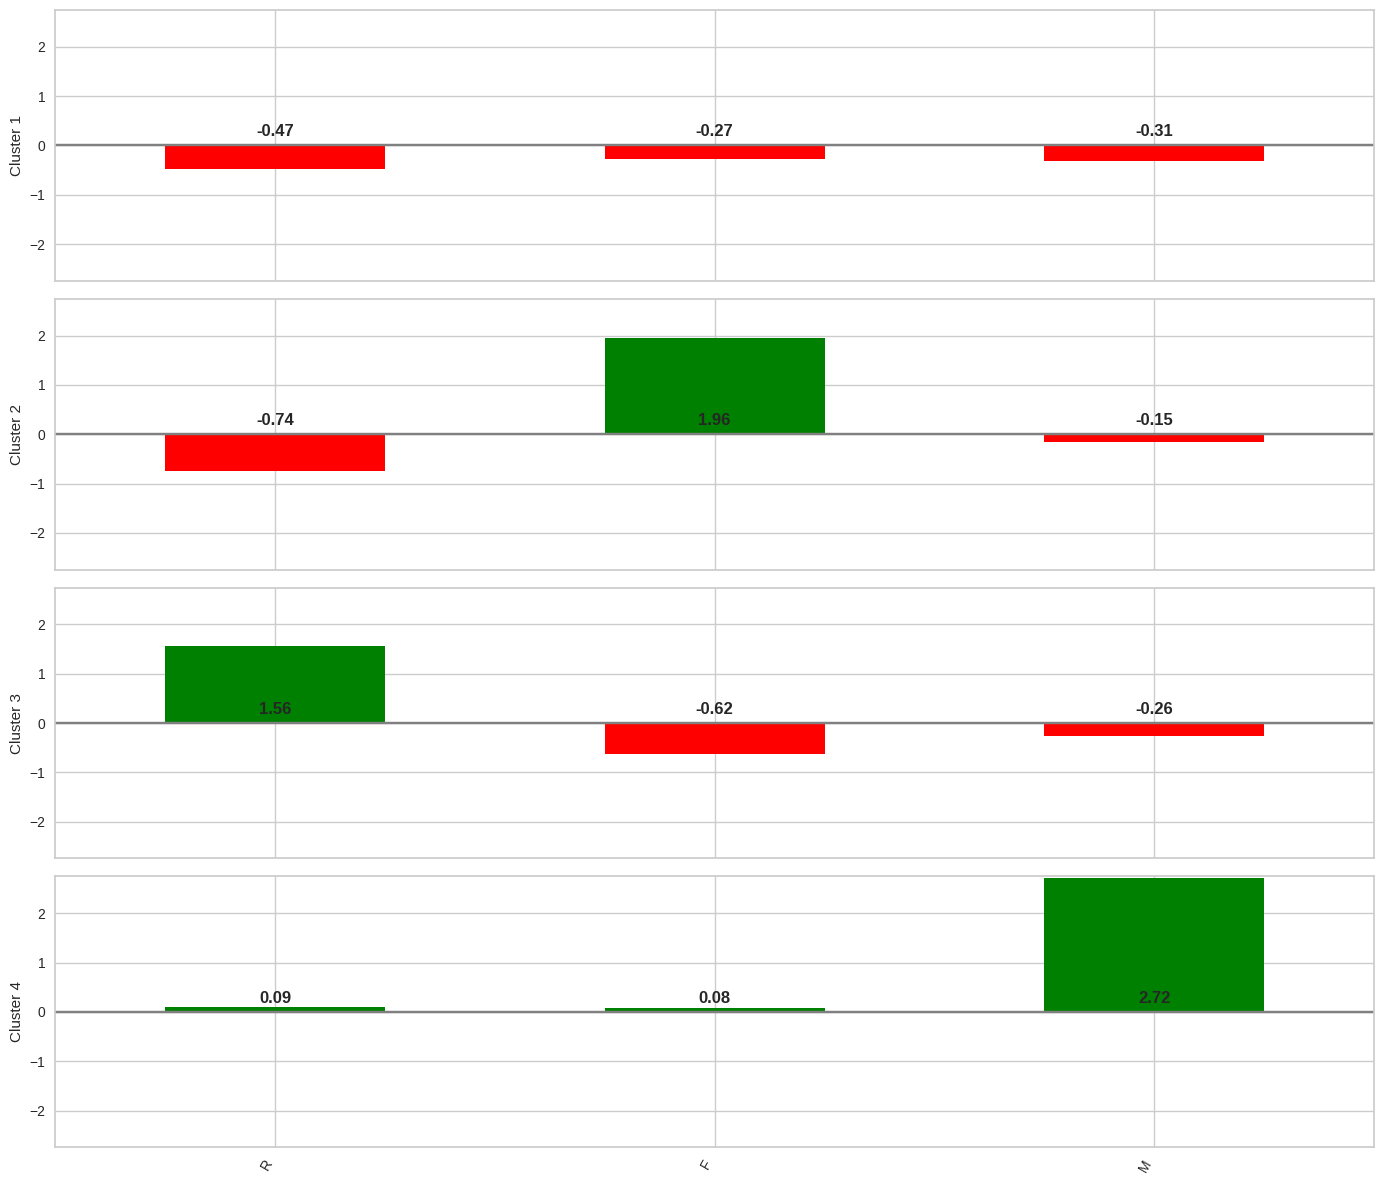

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)
maxPC = 1.01 * centers.abs().max().max()

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')
  for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., 0),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontweight='bold')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  df_rfm_clip.assign(cluster=labels_Kmeans)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='coolwarm', axis=1)
)

cluster,0,1,2,3
R,67.523221,41.517018,261.082051,121.057935
F,2.703877,10.191248,1.509744,3.876574
M,17.120301,20.426973,18.104189,80.714098
